# GANs (Generative Adversarial Networks)

El objetivo de este laboratorio es el de implementar GANs para generar imagenes de caras de animales. Se entrenaran 2 tipos de GANs, uno que genere imagenes con un solo canal y otro que genere imagenes con 3 canales(a colores)

Se utilizara el dataset Animal Faces (https://www.kaggle.com/datasets/andrewmvd/animal-faces)

In [1]:
import torch.nn as nn
import torch
import torchvision
import random
import matplotlib.pyplot as plt
import numpy as np
from fastprogress import master_bar, progress_bar
import zipfile
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Se carga el dataset

In [4]:
with zipfile.ZipFile('drive/MyDrive/Colab Notebooks/Animal_Faces.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
data_transform1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Lambda(lambda x: x.flatten()),
    torchvision.transforms.Lambda(lambda x: x * 2. - 1.)
])
data_transform2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.flatten()),
    torchvision.transforms.Lambda(lambda x: x * 2. - 1.)
])
trainset1 = torchvision.datasets.ImageFolder('afhq/train', transform=data_transform1)
trainset2 = torchvision.datasets.ImageFolder('afhq/train', transform=data_transform2)

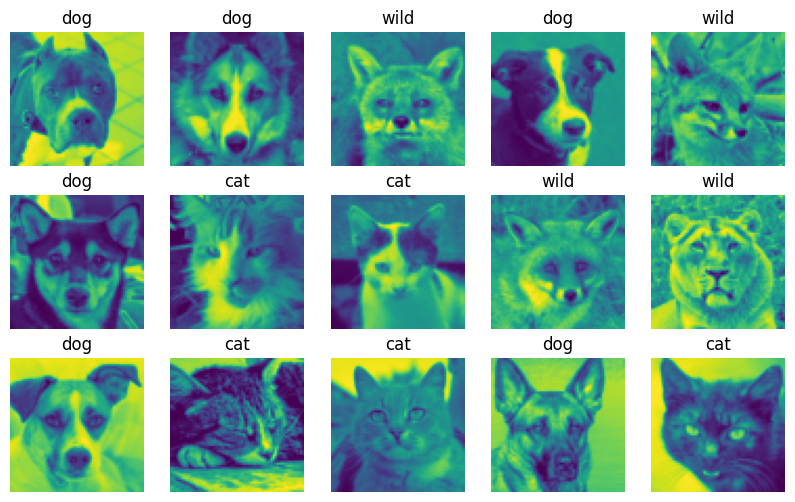

In [6]:
classes = ['cat','dog','wild']
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(trainset1)-1)
        img, lab = trainset1[ix]
        ax.imshow(img.reshape(64,64))
        ax.axis('off')
        ax.set_title(classes[lab])
plt.show()

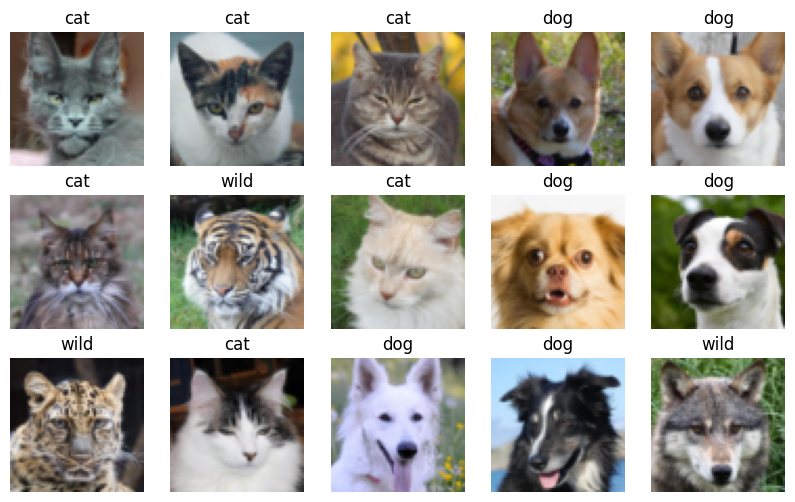

In [7]:
classes = ['cat','dog','wild']
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(trainset2)-1)
        img, lab = trainset2[ix]
        ax.imshow(img.reshape(3,64,64).permute(1,2,0)*0.5+0.5)
        ax.axis('off')
        ax.set_title(classes[lab])
plt.show()

Se crea los dataloaders

In [8]:
dataloader1 = torch.utils.data.DataLoader(trainset1, batch_size=32, shuffle=True)
dataloader2 = torch.utils.data.DataLoader(trainset2, batch_size=32, shuffle=True)

In [9]:
imgs, labels = next(iter(dataloader1))
imgs.shape, labels.shape

(torch.Size([32, 4096]), torch.Size([32]))

In [10]:
imgs, labels = next(iter(dataloader2))
imgs.shape, labels.shape

(torch.Size([32, 12288]), torch.Size([32]))

Se define la funcion que se encargara del entrenamiento

In [33]:
def fit(g, d, dataloader, epochs=5, lr=3e-4):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
    crit = nn.BCELoss()
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        if isinstance(d, Discriminator3) and epoch==5:
          d.unfreeze()
        for X, y in progress_bar(dataloader, parent=mb):
            X, y = X.to(device), y.to(device)
            # entrenamos el discriminador
            g.eval()
            d.train()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # input del discrminator
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # gorund truth para el discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimización
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # entrenamos el generador
            g.train()
            d.eval()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # salidas del discriminador
            d_output = d(genenerated_images)
            # gorund truth para el generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimización
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))
    torch.save(g, 'generador1.pt')
    torch.save(d, 'discriminador1.pt')
    return hist

# Generadores

In [11]:
class Generator(nn.Module):
    def __init__(self, channel=1):
        super(Generator, self).__init__()
        self.channel = channel
        self.init_size = 64 // 4
        self.input_size = 100
        self.l1 = nn.Sequential(nn.Linear(self.input_size, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, self.channel, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        img = img.view(img.size(0), self.channel*64*64)
        return img

In [ ]:
g = Generator(channel=3)
output = g(torch.randn(2, 100))
output.shape

torch.Size([2, 12288])

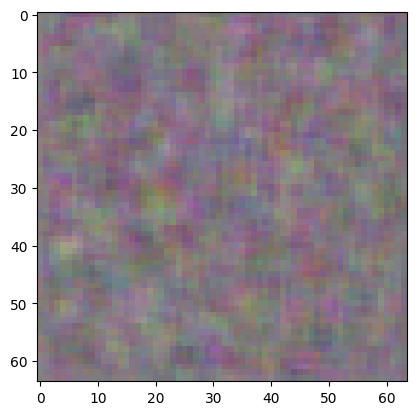

In [ ]:
plt.imshow(output[0].view(3,64,64).permute(1,2,0).detach().numpy()*0.5+0.5)
plt.show()

In [13]:
class Generator2(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.channel = channel
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size, 16*16*128),
        nn.BatchNorm1d(16*16*128),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.channel, 4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 128, 16, 16)
    x = self.main(x)
    x = x.view(x.size(0), self.channel*64*64)
    return x

In [ ]:
g_2 = Generator2(channel=3)
output = g_2(torch.randn(2, 100))
output.shape

torch.Size([2, 12288])

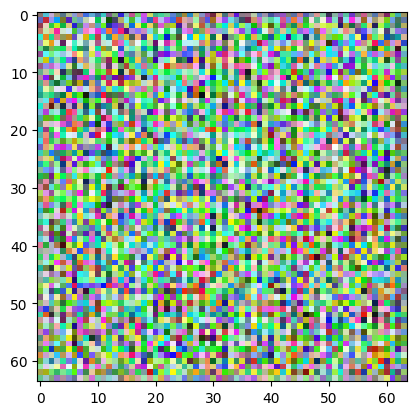

In [ ]:
plt.imshow(output[0].view(3,64,64).permute(1,2,0).detach().numpy()*0.5+0.5)
plt.show()

# Discriminadores

In [14]:
class Discriminator(nn.Module):
    def __init__(self, channel=1):
        super(Discriminator, self).__init__()
        self.channel = channel
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(self.channel, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = 64 // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        img = img.view(img.size(0), self.channel, 64, 64)
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [ ]:
d = Discriminator(channel=3)
output = d(torch.randn(2, 3*64*64))
output.shape

torch.Size([2, 1])

In [15]:
class Discriminator2(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.channel = channel
    self.main = nn.Sequential(
        nn.Conv2d(self.channel, 64, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True)
    )
    self.out = nn.Sequential(
        nn.Linear(128*16*16, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = x.view(x.size(0), self.channel, 64, 64)
    x = self.main(x)
    x = x.view(x.size(0), -1)
    x = self.out(x)
    return x

In [ ]:
d_2 = Discriminator2(channel=3)
output = d_2(torch.randn(2, 3*64*64))
output.shape

torch.Size([2, 1])

In [34]:
class Discriminator3(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.channel = channel
    convnext = torchvision.models.convnext_small(weights=True)
    self.convnext = nn.Sequential(*list(convnext.children())[:-1])
    for param in self.convnext.parameters():
      param.requires_grad = False
    self.fc = nn.Linear(768, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.view(x.size(0), self.channel, 64, 64)
    x = self.convnext(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    y = self.sigmoid(x)
    return y

  def unfreeze(self):
    for param in self.convnext.parameters():
      param.requires_grad = True

In [36]:
d_3 = Discriminator3(channel=3)
output = d_3(torch.randn(2, 3*64*64))
output.shape

torch.Size([2, 1])

In [22]:
isinstance(d_3, Discriminator3)

True

# Modelo 1

In [ ]:
generator1 = Generator(chanel=1)
discriminator1 = Discriminator(chanel=1)

In [ ]:
hist1 = fit(generator1, discriminator1, dataloader1, epochs=30)

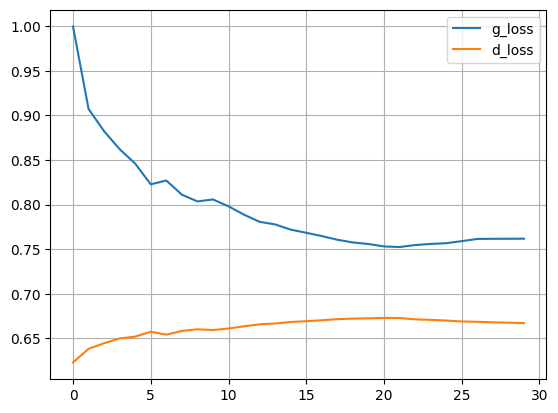

In [ ]:
df = pd.DataFrame(hist1)
df.plot(grid=True)
plt.show()

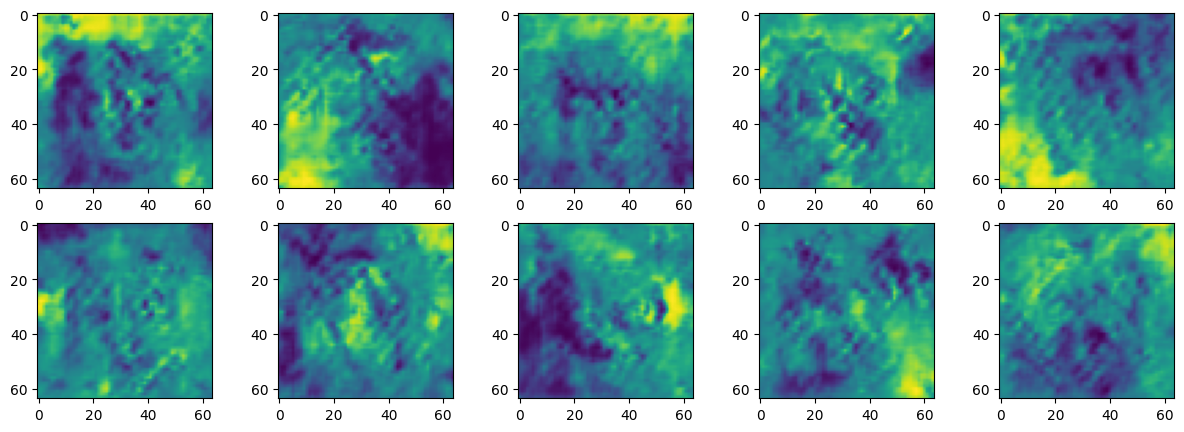

In [ ]:
generator1.eval()
with torch.no_grad():
  noise = torch.randn((10, generator1.input_size)).to(device)
  generated_images = generator1(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(64,64).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

# Modelo 2

In [ ]:
generator1_2 = Generator2(channel=1)
discriminator1_2 = Discriminator2(channel=1)

In [ ]:
hist1_2 = fit(generator1_2, discriminator1_2, dataloader1, epochs=30, lr=3e-3)

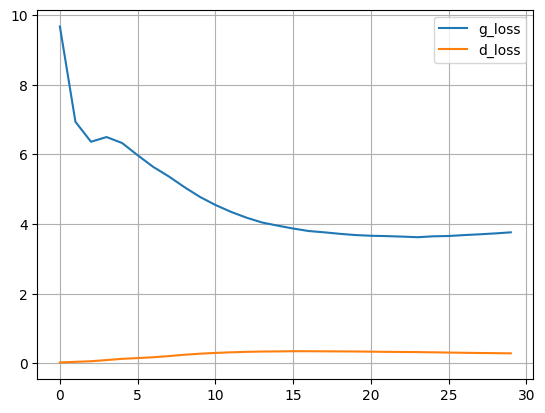

In [ ]:
df = pd.DataFrame(hist1_2)
df.plot(grid=True)
plt.show()

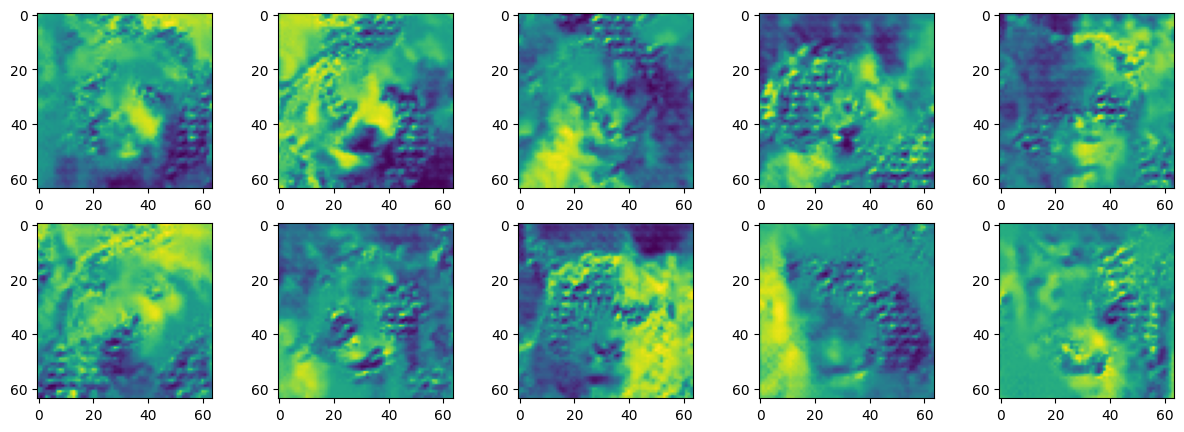

In [ ]:
generator1_2.eval()
with torch.no_grad():
  noise = torch.randn((10, generator1_2.input_size)).to(device)
  generated_images = generator1_2(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(64,64).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

# Modelo 3

In [ ]:
generator1_3 = Generator2(channel=1)
discriminator1_3 = Discriminator(channel=1)

In [ ]:
hist1_3 = fit(generator1_3, discriminator1_3, dataloader1, epochs=30)

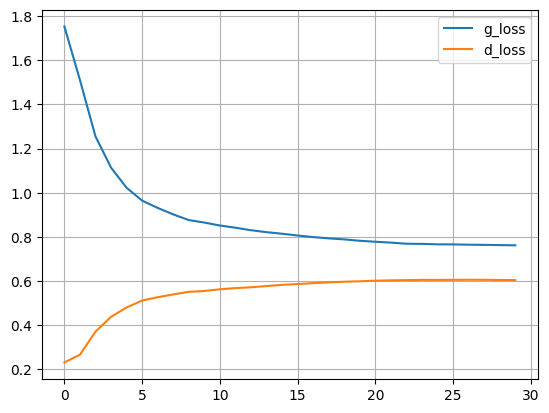

In [ ]:
df = pd.DataFrame(hist1_3)
df.plot(grid=True)
plt.show()

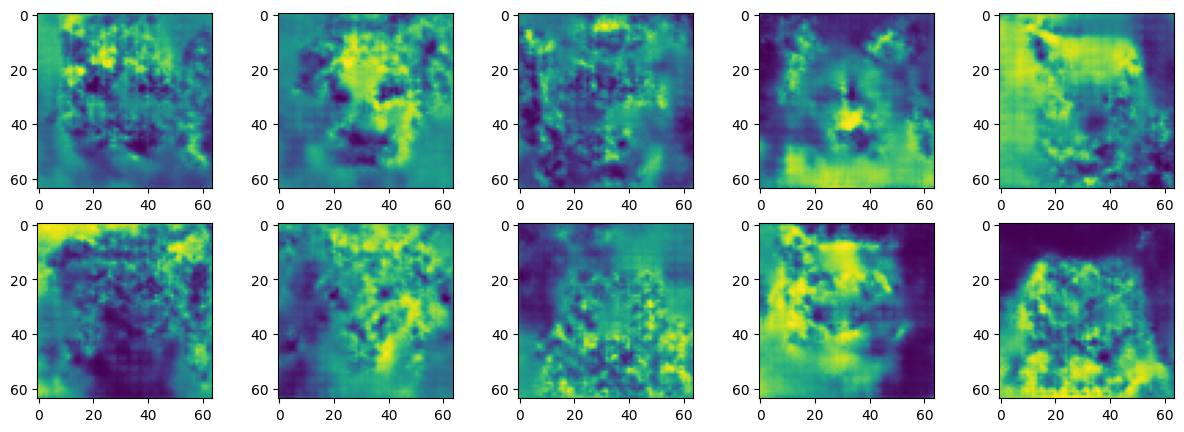

In [ ]:
generator1_3.eval()
with torch.no_grad():
  noise = torch.randn((10, generator1_3.input_size)).to(device)
  generated_images = generator1_3(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(64,64).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

# Modelo 4

In [ ]:
generator2 = Generator(channel=3)
discriminator2 = Discriminator(channel=3)

In [ ]:
hist2 = fit(generator2, discriminator2, dataloader2, epochs=20)

In [ ]:
def UnirLoss(d1,d2):
    resultado = {}
    for clave in d1.keys():
        resultado[clave] = d1[clave] + d2[clave]
    return resultado

In [ ]:
hist2 = UnirLoss(hist2,hist2)

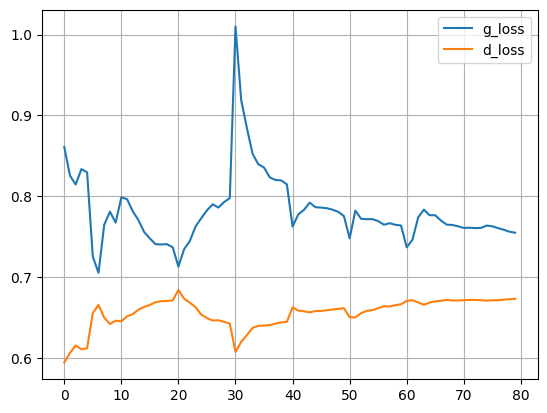

In [ ]:
df = pd.DataFrame(hist2)
df.plot(grid=True)
plt.show()

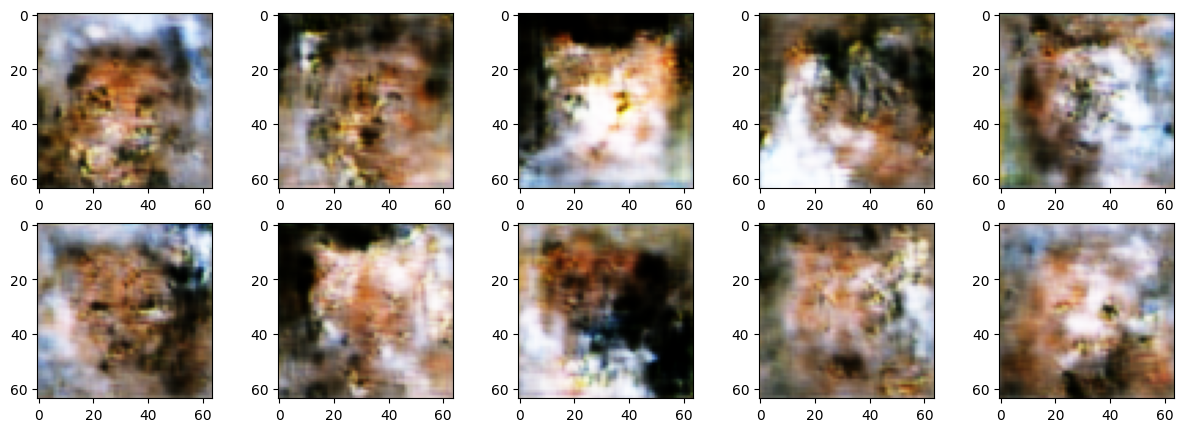

In [ ]:
generator2.eval()
with torch.no_grad():
  noise = torch.randn((10, generator2.input_size)).to(device)
  generated_images = generator2(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,64,64).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

# Modelo 5

Utilizando transfer learning en el discriminador

In [44]:
generator2_1 = Generator(channel=3)
discriminator2_1 = Discriminator3(channel=3)

In [45]:
hist2_1 = fit(generator2_1, discriminator2_1, dataloader2, epochs=20, lr=1e-3)

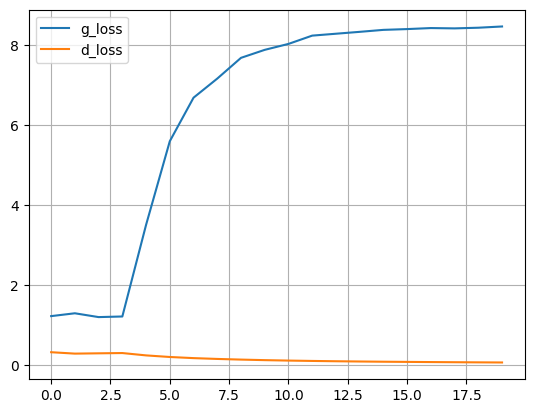

In [46]:
df = pd.DataFrame(hist2_1)
df.plot(grid=True)
plt.show()

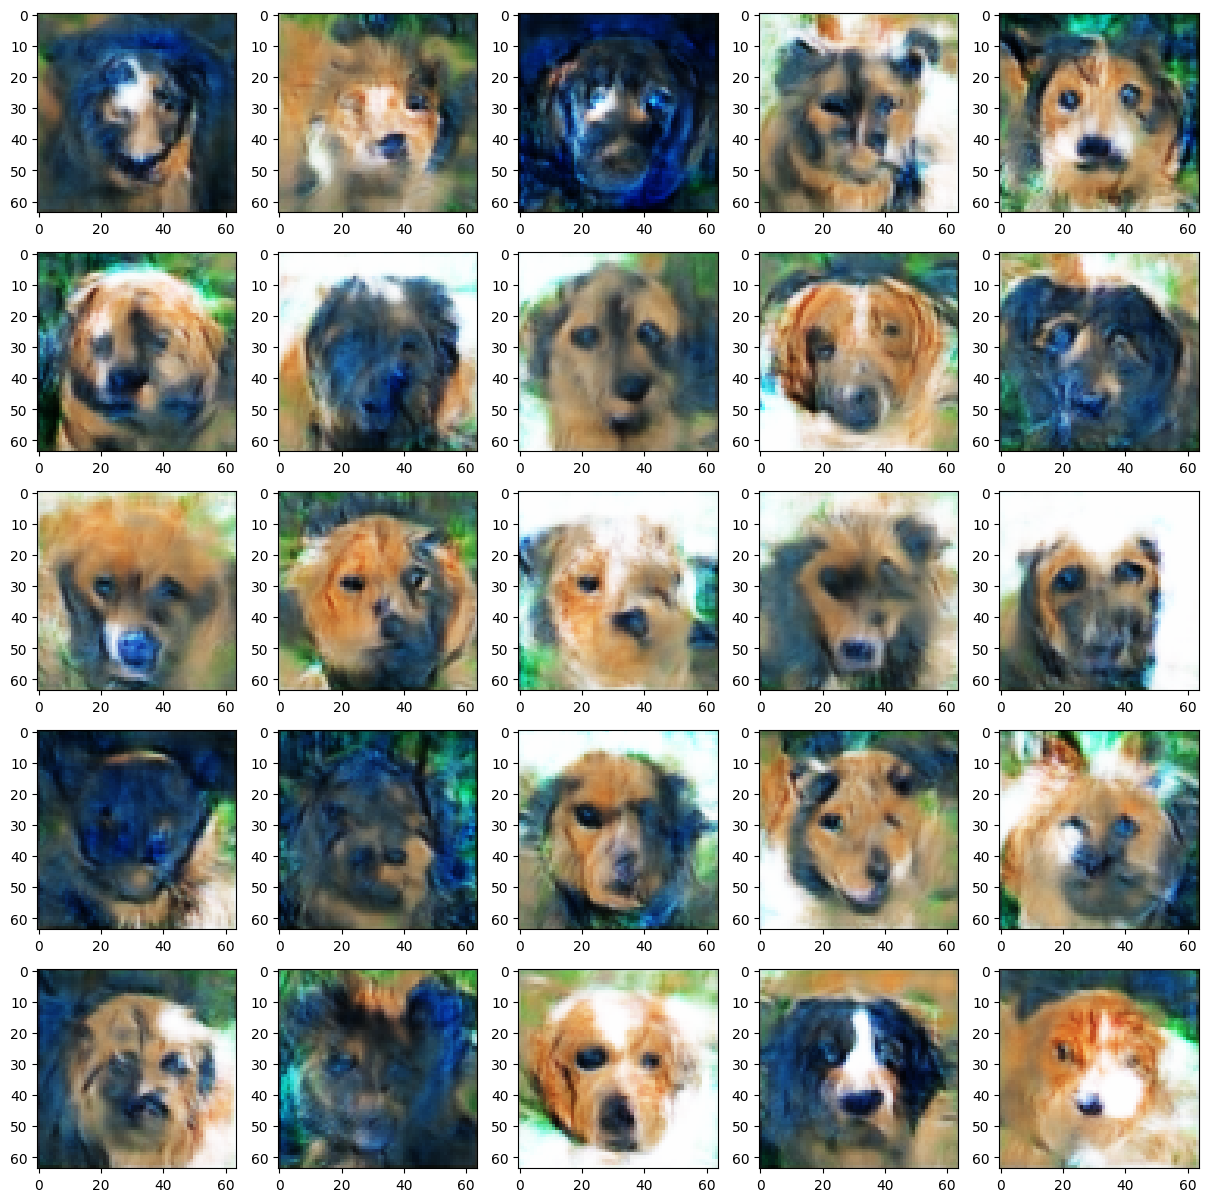

In [82]:
generator2_1.eval()
with torch.no_grad():
  noise = torch.randn((25, generator2_1.input_size)).to(device)
  generated_images = generator2_1(noise)
  fig, axs = plt.subplots(5,5,figsize=(15,15))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,64,64).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()